# An Intro to Quantum Effusion
#/* --------------------------------------------------------------------------------
###  Egorov Group
###   University of Virginia
###   Mohan Shankar, mjs7eek@virginia.edu
#-------------------------------------------------------------------------------- */

This Jupyter Notebook was created to introduce readers to the work being done in the Egorov Group along quantum mechanical lines. 

# Introduction

For academic and industrial pursuits, the relative and absolute rates of reactions are important pieces of information to hold, often dictating pathways which can produce better yields and control over attributes such as regioselectivity. Consequently, the problem of finding reaction rates is fundamental to our understanding of chemistry, resulting in the development of Transition-State Theory (TST) starting in the 1930’s.


Within the framework of TST, reaction rates are found using classical mechanics operating under the assumption that a well-defined dividing surface separating reactants and products known as the “transition-state” exists. 

<center>
<img src="tstate.png" width="400">
</center>

Classical TST has been very effective at calculating reaction rates for systems involving heavy atoms at high temperatures, but it often fails for the quantum regime where phenomena such as tunneling and zero-point energy occur. To this end, there is a need of creating a quantum transition state theory where these effects are accounted for. A cool example can be found in this [paper](https://pubs.acs.org/doi/10.1021/jacs.7b06905) detailing a double-Hydrogen transfer where quantum effects play a significant role.

For classical transition state, the key assumption is the existence of a **dividing surface** that perfectly separates reactants from products with no chance of recrossing (i.e. no products back to reactants). Since TST was developed in the 1930's, the theory that was used to corroborate results was effusion of gases as a clear dividing surface also existed there. The **goal** of this project is to create a quantum effusion system through modifying a particle in a box system, affording us a baseline for future comparison.

<center>
<img src="system.png" width="800">
</center>

The image on the right of the arrow represents the system we make. Although effusion is a process that occurs resulting in gas occupying empty space, computers can't fathom that idea so we make a sufficiently large box instead to represent "outside."

## Density Operators:

I think the correlation functions are the trickiest and coolest part of the whole work. In particular, we feed in *density operators* rather than wavefunctions associated with a particular state so that the correlation functions can work over all considered possibilities. I think a great explanation of what a density operator is can be found in this [video](https://youtu.be/DQEtg8pWT8E?si=5tLHtlSTs-6e1iRn). 

# Explanatory Pieces of Code

## General Workflow:

For this project, there are three sections to go through where the latter two are the novel ones. 

<center>
<img src="flow.png" width="900">
</center>

1) **Solver Validation:** While the PIB has known solutions (i.e. we know what $\psi$ and $E_n$ are), the effusion system we will later create **does not** have known solutions, so we have to solve the Schrödinger Equation numerically. As a result, we want to make sure our analytic solutions match the numeric results

2) **Add Slit:** Setting certain elements in the Hamiltonian is the numerical equivalent of imposing boundary conditions, meaning that we force $\psi = 0$ at those points in the system

3) **Find Rate Constants:** This step involves calculating $\left< i | \hat{F} | j \right>^2 $ and performing the necessary subsequent steps to find the correlation functions. The boxed in one above is the flux-side correlation function, and we can find its limit at an intermediate time to extract the rate constants from.

Actual explanatory code will mainly focus on creation of the Hamiltonian, finding rate constants, and extrapolating rate constants.

### Creation of the Hamiltonian 

The project can generally be split up into two steps: creation of the Hamiltonian and finding correlation functions. In the differential form, the Hamiltonian for the particle in a box looks like

$$ \hat{H} = - \frac{\hbar^2}{2m} \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) $$

since there's no potential energy term. That being said, computers don't understand continuous things, so they can't take a derivative how we can. As a result, people developed algorithms to numerically find derivatives, and the one we will focus on is the finite difference method. A splendid video that covers this concept far better than I can is located [here](https://youtu.be/YotrBNLFen0?si=1Zcn6Yi579sAhXnq). The key takeaway is how a system is carved up (discretized) by placing a finite number of points inside so that we could implement particular numerical methods. Of course, the numerical solutions gets more accurate as the number of points $\to \infty$ but that's computationally expensive.

Generally speaking, a 2nd order derivative is typically written as 

$$ f(x_{i + 1}) - 2 f(x) + f(x_{i-1}) \, . $$
For our work, however, we use a bit more advanced of a weighting scheme highlighted below:

<center>
<img src="weights.png" width="600">
</center>

Notice at the top, the weights I wrote out above are employed. We use the green boxed in weights since we assume there are an infinite number of points outside the box, but we can disregard it since we "set those values to zero" as $\psi$ cannot exist outside the box. If we imagine a $2 \times 2$ particle in a box, the subsequent Hamiltonian would be $4 \times 4$ and looks as follows:

<center>
<img src="ham.png" width="700">
</center>

Generally, having nnx points along the x-axis and nny points along the y-axis will results in an $[nnx \cdot nny \times nnx \cdot nny]$ matrix.

The last thing to do is define the actual $\frac{\partial}{\partial x}$ and $\frac{\partial}{\partial y}$ components. This is done by finding the total distance along one axis you want to consider then divide it by the number of points along that axis. If we think of dx or dy as an infinitesimally small distance between two points, we can re-create is by finding the space between each point used in discretizing our system. This looks like:

$$ dn = \frac{L_{max} - L_{min}}{n - 1} $$

Here, we use n-1 to grab the distances *between* points, but the code below will actually use n+1 in order to include the walls as  well. Numerically, it's a very subtle distinction. The last thing to note is that for this code, we do everything in atomic units characterized by setting $\hbar = 1$ among other things for ease of computation.

Another thing we can do for the ease of computation is take the *Kronecker Sum* of two 1D Hamiltonians to make the 2D one. Why this works would require some math discussion, so I'll leave that alone for now. The 1D Hamiltonians are weighted the same way as above. The only distinction is that you only consider the derivative along one axis. Let's take a look at some example code for building our Hamiltonian below:

In [56]:
#/* --------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   Hamiltonian.py
#   "This file calculates eigenfunctions of particle in a box in the presence of a slit"
#-------------------------------------------------------------------------------- */
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
import time
#-------------------------------------------------------------------------------- */
start_time = time.time()


# INPUTS
me = 5.485799e-4 # Electron mass in daltons
m_au = 1.0 / me

lx = 1.0 # Angstroms
ly = 1.0 # Angstroms

a0 = 0.529177258 # Bohr radius

lx_au = lx/a0
ly_au = ly/a0 

nnx = 2 # number of points in x; set this to 2 to match above image
nny = 3 # number of points in y; set this to 2 to match above image 

xmin = 0
xmax = lx_au

ymin = 0
ymax = ly_au

dx = (xmax-xmin)/(nnx+1)
dy = (ymax-ymin)/(nny+1)

pi = np.pi

#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

def kron_sum(A1, A2):
    '''
    Assumes A1, A2 are nxn, mxm matrices where n can be equal to m
    '''
    i1 = np.identity(len(A1[0]))
    i2 = np.identity(len(A2[0]))
    return np.kron(A1,i2) + np.kron(i1, A2)


def PIB_one(points, lmax, lmin, mass, hbar=1):  
    '''
    function to return eigenvalues and eigenvectors of a Hamiltonian matrix 
    eigvals returned in array where eigvals[0] gives a float corresponding to n = 1; units of Joules since I defined my analytic formula with SI units
    eigvecs returned in array of arrays where eigvecs[:, i] (column vectors) gives an array corresponding to n = i at each point in the box defined by grid spacing dx
    '''
    dn = (lmax-lmin)/(points+1)
    dn2 = dn**2  # second derivative
    H = np.zeros((points, points)) # initialize 
    z = -pi**2/3.0  # weight for diagonal
    for i in range(points):
        for j in range(points):
            if i == j:
                H[i][j] = z # weight for diagonals of matrix
            else:
                H[i][j] = (2/(i-j)**2)*((-1)**(i-j+1))  # weights for non-diagonals
    
    H_final = H * (-1/(2*mass*dn2)) # hbar = 1 hence 1/(2 * mass * dn2)
    return H_final, H
#-------------------------------------------------------------------------------- */
# CREATE MATRICES 
h1_x, simple_h1x = PIB_one(nnx, xmax, xmin, m_au) # 1-D Hamiltonian from x points
h1_y, simple_h1y = PIB_one(nny, ymax, ymin, m_au) # 1-D Hamiltonian from y points

H_simple = kron_sum(simple_h1x, simple_h1y)
H = kron_sum(h1_x, h1_y)

print("Our Simple 1D Hamiltonian along x Looks Like: \n {}".format(simple_h1x))
print("Our Simple 1D Hamiltonian along y Looks Like: \n {}".format(simple_h1y))
print("Our Simple 2D Hamiltonian Looks Like: \n {}".format(H_simple))

Our Simple 1D Hamiltonian along x Looks Like: 
 [[-3.28986813  2.        ]
 [ 2.         -3.28986813]]
Our Simple 1D Hamiltonian along y Looks Like: 
 [[-3.28986813  2.         -0.5       ]
 [ 2.         -3.28986813  2.        ]
 [-0.5         2.         -3.28986813]]
Our Simple 2D Hamiltonian Looks Like: 
 [[-6.57973627  2.         -0.5         2.          0.          0.        ]
 [ 2.         -6.57973627  2.          0.          2.          0.        ]
 [-0.5         2.         -6.57973627  0.          0.          2.        ]
 [ 2.          0.          0.         -6.57973627  2.         -0.5       ]
 [ 0.          2.          0.          2.         -6.57973627  2.        ]
 [ 0.          0.          2.         -0.5         2.         -6.57973627]]


### Hamiltonian Results 

After the Hamiltonian is generated, the eigenvectors $\psi_n$ and eigenvectors $E_n$ are found, but this is shown in the full code rather than above. 

### Finding Rate Constants

Not much to explain here. We take a numerical derivative along the flux-side correlation function and find where it's ~0, saving the domains before finding the longest one to use at the intermediate limit in time.

Partition Functions: 
 [8.63930324e-03 9.82193204e-02 4.22178739e-01 8.24743160e-01
 1.15425738e+00 1.73690949e+00 2.34854034e+00 2.98075566e+00
 3.62856891e+00 4.28873106e+00 5.63768857e+00 7.01575693e+00
 8.41588408e+00 9.83347522e+00 1.12653388e+01 1.27091510e+01]
Tuples (40, 482)
Tuples (489, 526)
Tuples (543, 576)
Tuples (624, 646)
Tuples (662, 694)
Tuples (749, 975)
Number of index used 261.0
Value of csf 1.3313e-06
Time 2610.0
Rate [Hz] [2.9386848e+09]
Truncated Rate [Hz] [2.939e+09]


/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_4390/862443966.py:76: RuntimeWarning:

invalid value encountered in divide



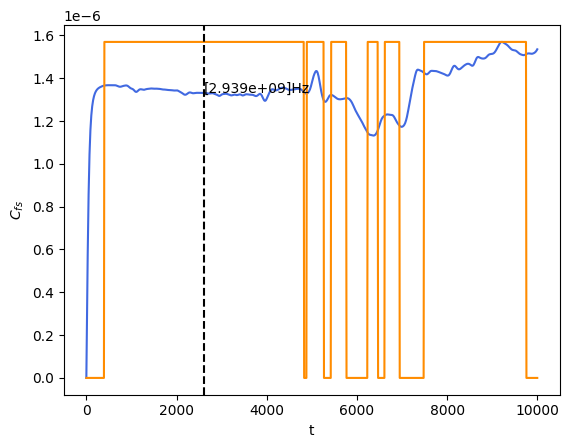

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Trange = np.array([100, 200, 400, 600, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

hbar = 1.054571817e-34 # hbar in SI Units [J*s]

m = 1.67262192e-27 # mass of proton in kg

L = 1e-10 

kb = 1.380649e-23

#-------------------------------------------------------------------------------- */
# Calculate Partition Functions
n = np.arange(1, 21, 1)
Q = np.empty(shape = len(Trange)) # initialize empty array of dimensions equal to Trange
E = (np.pi ** 2 * hbar ** 2) / (2 * m * L ** 2)

for i, temp in enumerate(Trange):
    T = temp
    beta = 1 / (kb * T)
    zz = np.exp(-beta * E * n** 2)
    final = np.sum(zz)
    Q[i] = final**2

print("Partition Functions: \n", Q)

#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

T = 1500 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE TEMPERATURE

chunk_size = 50 # NUMBER OF POINTS FORWARD AND BACK TO CONSIDER IN DERIV.

wall_size = 3 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE WALL SIZE

gap_size = 6 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE GAP SIZE


temp_index = np.where(Trange == T) # get index of Trange array where the temperature match 
#-------------------------------------------------------------------------------- */
# READ IN DATA

df = pd.read_csv("/Users/mohan/Desktop/Research/pib_review/data/"+str(wall_size)+"pt_wall/"+str(gap_size)+"pt_gap/side-flux"+str(Trange[temp_index][0])+"K.txt") # read in data

# df = pd.read_csv("/Users/mohan/Desktop/Refile/2pt_wall/6pt_gap/side-flux"+str(Trange[temp_index][0])+".txt", sep = ' ', header = None).T # if Alec style; my 2 pt wall, 6pt gap are Alec style

t = df.iloc[:, 0].to_numpy() # first column is time array
c = df.iloc[:, 1].to_numpy() # second column is correlation function array

#-------------------------------------------------------------------------------- */
# DEFINE FUNCTIONS
def zero_slope(data, chunksize = chunk_size, max_slope = .04): # function to find where the numerical derivative is ~ 0 based on chunk size 
    # (looking at points forwards and backwards) and max_slope
    midindex = chunksize / 2
    is_plateau = np.zeros((data.shape[0]))
    for index in range(int(midindex), len(data) - int(midindex)):
        front = index - midindex
        back = index + midindex
        chunk = data[int(front) : int(back)]
        dy_dx = abs(chunk[0] - chunk[-1])/chunksize
        if (0 <= dy_dx < max_slope):
            is_plateau[index] = 1.0
    return is_plateau

def ranges(nums): # return tuples of consecutive integers (i.e. find "widths" of plateaus in step function)
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
#-------------------------------------------------------------------------------- */
# ANNOYING STUFF
small = np.nanmin(c/t) # find min of c/t wile dropping NaN values

step_function = zero_slope(data = c, chunksize = chunk_size, max_slope = small*10) # array of all 0's and 1's based on where the plateaus are

indices = [idx for idx,val in enumerate(step_function) if val == 1] # grab indices where value is 1

new = ranges(indices) # create tuples of consecutive numbers (i.e. find indices for each plateau)

lengths = np.zeros(len(new)) # make empty array with same dimensions as "new" array 

for i, val in enumerate(new): # print out tuples
    print("Tuples", val)
    lengths[i] = val[1] - val[0] 

#-------------------------------------------------------------------------------- */
# NUMERICALLY FIND LARGEST PLATEAU AND SET INDEX (`use_this`) TO THE MIDDLE INDEX OF LONGEST PLATEAU

max_value = max(lengths)
max_index = list(lengths).index(max_value)

largest_tuple = new[max_index]

# automatically find widest plateau numerically
# index for y value of csf we want to use for calculating the rate 

use_this = (largest_tuple[0] + (largest_tuple[1] - largest_tuple[0])/2)

# use_this = (40 + (59 - 40)/2) # manually set index for widest plateau; index for y value of csf we want to use for calculating the rate 

print("Number of index used", use_this)

csf = c[int(use_this)]

print("Value of csf", csf)

print("Time", t[int(use_this)])

rate = (csf/Q[temp_index]) * 6.57966e15 # rate; multiply hartree value by conversion factor to get Hz
print("Rate [Hz]", rate)
short_rate = np.around(rate, decimals = -6)
print("Truncated Rate [Hz]", short_rate)
#-------------------------------------------------------------------------------- */
# PLOT
plt.plot(t, c, color = 'RoyalBlue')
plt.plot(t, step_function*np.nanmax(c), color = 'darkorange') # scale the step function by the maximum of the correlation function so that plotting makes sense
plt.axvline(x = t[int(use_this)], color = 'k', linestyle = '--', label = 'plateau value')
plt.text(t[int(use_this)], c[int(use_this)] + np.nanmin(c), str(short_rate)+"Hz")
plt.xlabel("t")
plt.ylabel(r"$C_{fs}$")
# plt.savefig("/Users/mohan/Desktop/well-behaved_ff_1000k_2wall_6gap.png", dpi = 500)
plt.show()

### Rate Constant Extrapolation

For our system, there are three main parameters: gap size, temperature, and wall thickness. Mathematically, TST and QTST work at infinitely thin wall thickness, so we need to extrapolate the rate constants as wall thickness goes to 0. To this end, we hold temperature and gap size fixed.

<center>
<img src="effus_system.png" width="700">
</center>

Diagram of the system, not to scale. The black points represent how the system was spatially discretized. The red lines represent walls where the wavefunction and at and outside the walls are set to zero. The blue line represents the dividing surface separating the reactant region (left box) and empty space (right box). Finally, the blue curly brace denotes the gap size while the black curly brace marks wall thickness.

### The following code shows how the rate constants are extrapolated as wall thickness tends to 0.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("/Users/mohan/Desktop/Research/thesis/rates/all_rates_clean.xlsx").dropna()

In [9]:
df # display what was in the excel document

,Temperature [K],Wall Thickness,Gap Size,Rate
0,100,1,2,1.160000e+07
1,200,1,2,1.310000e+07
2,400,1,2,2.230000e+07
3,600,1,2,3.610000e+07
4,750,1,2,4.970000e+07
...,...,...,...,...
395,3000,5,10,1.496231e+11
396,3500,5,10,1.935069e+11
397,4000,5,10,2.366368e+11
398,4500,5,10,2.782765e+11


In [37]:
T = 1500
gap_size = 6


filtered_df = df[(df['Temperature [K]'] == T) & (df['Gap Size'] == gap_size)]

# Take the first five rows that meet the criteria
result = filtered_df.head(5)

In [38]:
result # show filtered out results 

,Temperature [K],Wall Thickness,Gap Size,Rate
39,1500,1,6,1.530000e+10
119,1500,2,6,6.551724e+09
199,1500,3,6,2.938600e+09
279,1500,4,6,1.343632e+09
359,1500,5,6,6.197660e+08


In [39]:
wall_thickness = result.iloc[:, 1]
rates = np.log10(result.iloc[:, -1]) # take log base 10 of rate constants

rates

39     10.184691
119     9.816356
199     9.468140
279     9.128280
359     8.792228
Name: Rate, dtype: float64

Rate Constants: 
 39     10.184691
119     9.816356
199     9.468140
279     9.128280
359     8.792228
Name: Rate, dtype: float64
Fit: [ 5.20867750e-03 -3.78552319e-01  1.05563006e+01]
Extrapolated Rate Constant: 10.556300635396822
Extrapolated Error: 0.007932190001653081
Fixed Rate: 3.599985e+10


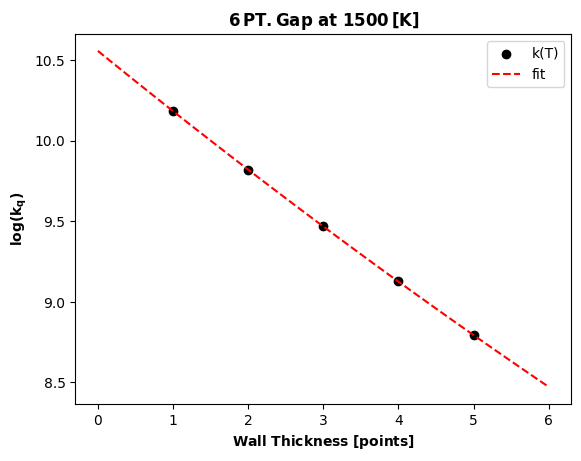

In [44]:
# fit polynomial to k vs. wall thickness

order = 2 # change the order b/t 1 (linear), 2 (quadratic), and 3 (cubic) to see how the fits and error changes

fit, cov_matrix = np.polyfit(wall_thickness, rates, order, cov = True) # fit 3rd order polynomial to data and return covariance matrix

print("Rate Constants: \n {}".format(rates))

errors = np.sqrt(np.diag(cov_matrix))

print("Fit:", fit)

quad_sum = np.sqrt(np.sum(np.square(errors))) # find quadrature sum to propagate error

x = np.linspace(0, 6, 100)

# FOR THE SAKE OF PLOTTING
if order == 3:
    y = fit[0] * x**3 + fit[1] * x**2 + fit[2] * x + fit[3] # 3rd order polynomial
elif order == 2:
    y = fit[0] * x**2 + fit[1] * x + fit[2] # 2nd order polynomial
elif order == 1:
    y = fit[0] * x + fit[1]  # 1st order polynomial

# FOR THE SAKE OF PLOTTING

print("Extrapolated Rate Constant:", fit[-1]) # grab last element of array which corresponds to weight for lowest order term, i.e. the y-intercept 
print("Extrapolated Error:", errors[-1])

print("Fixed Rate: {:e}".format(10**fit[-1]))

plt.scatter(wall_thickness, rates, color = 'k', label = 'k(T)')
plt.plot(x, y, color = 'r', linestyle = '--', label = 'fit')
plt.xlabel(r'$\bf{Wall \, \, Thickness \, \, [points]}$')
plt.ylabel(r'$\bf{log(k_q)}$')
plt.legend()
plt.title(r'$ \bf{6 \, PT. Gap \, \,  at \, \, 1500 \, [K]}$')
plt.show();

# Figure Creation:

## Effusion System 

Matrices created!
Slit created!
Eigs found!
(array([  20,   21,   22, ..., 3197, 3198, 3199]),)
Eigs done!


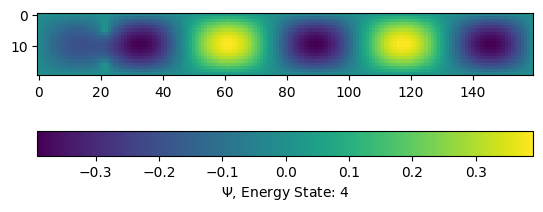

In [11]:
#/* --------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   effusion_plotter.py
#   "This file calculates eigenfunctions of particle in a box in the presence of a slit"
#-------------------------------------------------------------------------------- */
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
import time
#-------------------------------------------------------------------------------- */
start_time = time.time()


# INPUTS
me = 5.485799e-4 # Electron mass in daltons
m_au = 1.0 / me

lx = 1.0 # Angstroms
ly = 8.0 # Angstroms

a0 = 0.529177258 # Bohr radius

lx_au = lx/a0
ly_au = ly/a0 

nnx = 20 # number of points in x; set low for debugging
nny = 160 # number of points in y; set low for debugging

xmin = 0
xmax = lx_au

ymin = 0
ymax = ly_au

dx = (xmax-xmin)/(nnx+1)
dy = (ymax-ymin)/(nny+1)

pi = np.pi

nd = 2 # length of stencil 
wall_thickness = 2
cd = np.zeros(nd) 
nn = 10 # number of points on dividing surface?
gap_size = 10.0
#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

def kron_sum(A1, A2):
    '''
    Assumes A1, A2 are nxn, mxm matrices where n can be equal to m
    '''
    i1 = np.identity(len(A1[0]))
    i2 = np.identity(len(A2[0]))
    return np.kron(A1,i2) + np.kron(i1, A2)


def PIB_one(points, lmax, lmin, mass, hbar=1):  
    '''
    function to return eigenvalues and eigenvectors of a Hamiltonian matrix 
    eigvals returned in array where eigvals[0] gives a float corresponding to n = 1; units of Joules since I defined my analytic formula with SI units
    eigvecs returned in array of arrays where eigvecs[:, i] (column vectors) gives an array corresponding to n = i at each point in the box defined by grid spacing dx
    '''
    dn = (lmax-lmin)/(points+1)
    dn2 = dn**2  # second derivative
    H = np.zeros((points, points)) # initialize 
    z = -pi**2/3.0  # weight for diagonal
    for i in range(points):
        for j in range(points):
            if i == j:
                H[i][j] = z # weight for diagonals of matrix
            else:
                H[i][j] = (2/(i-j)**2)*((-1)**(i-j+1))  # weights for non-diagonals
    H *= (-1/(2*mass*dn2)) # hbar = 1 hence 1/(2 * mass * dn2)
    return H
#-------------------------------------------------------------------------------- */
# CREATE MATRICES 
h1_x = PIB_one(nnx, xmax, xmin, m_au) # 1-D Hamiltonian from x points
h1_y = PIB_one(nny, ymax, ymin, m_au) # 1-D Hamiltonian from y points

H = kron_sum(h1_x, h1_y) # 2-D Hamiltonian
# STENCIL FOR FLUX ALONG DIVIDING SURFACE
for k in range(nd):
    zz = 1.0
    for j in range(nd):
        if j != k:
            zz *= ((j+1)**2) / ((j+1)**2 - (k+1)**2)
        else:
            continue
    cd[k] = zz/(2*(k+1))

print("Matrices created!")
#-------------------------------------------------------------------------------- */
# MAKE EFFUSION SLIT BY ZEROING OUT HAMILTONIAN
i = -1

for k in range(nnx):
    for j in range(nny):
        i = i+1
        x = dx * k + xmin
        y = dy * j + ymin
        if (1.0 / a0) < y < (1.0 / a0 + wall_thickness * dy):
            if x <(0.5 * xmax - (gap_size/2) * dx) or x >(0.5 * xmax + (gap_size/2) * dx):
                H[i] = np.zeros(nnx * nny)
                H[:, i] = np.zeros(nnx * nny)
                H[i, i] = -1
print("Slit created!")
#-------------------------------------------------------------------------------- */
# CALCULATE EIGENVECTORS AND VALUES
eigvals, eigvecs = np.linalg.eigh(H) # find eigenvalues and eigenvectors
print("Eigs found!")
#-------------------------------------------------------------------------------- */
# CLEANUP OF DATA
psi = np.transpose(eigvecs) # vectors returned in column form so take transpose for easier indexing

psi = psi[np.argsort(eigvals)]
energies = eigvals[np.argsort(eigvals).real]

cut = np.where(energies > 0)
print(cut)
energies = energies[cut]
psi = psi[cut]

for i in range(len(psi)):
    normalization = np.sqrt(np.sum(psi[i]**2 * dy * dx))
    psi[i] = psi[i]/normalization

print("Eigs done!")
#-------------------------------------------------------------------------------- */
# PLOTTING
a = 4 # excited state value

psi_plot = psi[a].reshape(nnx, nny)
psi_2 = psi[a]**2

x1, y2 = np.linspace(0, xmax, nnx), np.linspace(0, ymax, nny) 
x, y = np.meshgrid(y2, x1)

num_plot = plt.imshow(psi_plot.reshape(nnx, nny))
num_cb = plt.colorbar(num_plot, orientation = 'horizontal')
num_cb.set_label(r"$\Psi $, Energy State: "+str(a))
# plt.savefig("/Users/mohan/Desktop/2pt_wall-10pt_gap-"+str(a)+"excited.png", dpi = 600)

plt.show()
#-------------------------------------------------------------------------------- */


## Ratio of Analytic to Numeric Eigenvalues

In [45]:
#-------------------------------------------------------------------------------- */
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
#-------------------------------------------------------------------------------- */
# DECLARE VARIABLES
import scipy.constants
hbar = scipy.constants.hbar
m = scipy.constants.m_p
L = 1e-10

pi = scipy.constants.pi

har_to_j = 4.35974e-18
#-------------------------------------------------------------------------------- */
# SET ANALYTIC PARAMETERS
n = np.arange(1, 61, 1)

nx = np.arange(1, 31, 1)
ny = np.arange(1, 31, 1)

m = 1.67262192e-27 # mass of proton in kg
#-------------------------------------------------------------------------------- */
# CALCULATE ANALYTIC VALUES
final = np.ones((len(nx), len(ny)))

for i, val1 in enumerate(nx):
    for j, val2 in enumerate(ny):
        E_ij = ((hbar**2 * pi**2)/ (2 * m * L**2) * (i**2 + j**2))
        final[i][j] = E_ij

analytic = final.reshape((len(nx)* len(ny)))

sorted_ana = np.sort(analytic)

sorted_ana_final = sorted_ana[0:]

# print(sorted_ana_final)
#-------------------------------------------------------------------------------- */
# INPUTS
me = 5.485799e-4 # Electron mass in daltons
m_au = 1.0 / me

lx = 1.0 # Angstroms
ly = 8.0 # Angstroms

a0 = 0.529177258 # Bohr radius

lx_au = lx/a0
ly_au = ly/a0 

nnx = 20
nny = 160 

xmin = 0
xmax = lx_au

ymin = 0
ymax = ly_au

dx = (xmax-xmin)/(nnx+1)
dy = (ymax-ymin)/(nny+1)

pi = np.pi

nd = 2 # 
wall_thickness = 1
cd = np.zeros(nd) 
nn = 10000 

gap_size = 4.0
#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

def kron_sum(A1, A2):
    '''
    Assumes A1, A2 are nxn, mxm matrices where n can be equal to m
    '''
    i1 = np.identity(len(A1[0]))
    i2 = np.identity(len(A2[0]))
    return np.kron(A1,i2) + np.kron(i1, A2)


def PIB_one(points, lmax, lmin, mass, hbar=1):  
    '''
    function to return eigenvalues and eigenvectors of a Hamiltonian matrix 
    eigvals returned in array where eigvals[0] gives a float corresponding to n = 1; units of Joules since I defined my analytic formula with SI units
    eigvecs returned in array of arrays where eigvecs[:, i] (column vectors) gives an array corresponding to n = i at each point in the box defined by grid spacing dx
    '''
    dn = (lmax-lmin)/(points+1)
    dn2 = dn**2  # second derivative
    H = np.zeros((points, points)) # initialize 
    z = -pi**2/3.0  # weight for diagonal
    for i in range(points):
        for j in range(points):
            if i == j:
                H[i][j] = z # weight for diagonals of matrix
            else:
                H[i][j] = (2/(i-j)**2)*((-1)**(i-j+1))  # weights for non-diagonals
    H *= (-1/(2*mass*dn2)) # hbar = 1 hence 1/(2 * mass * dn2)
    return H
#-------------------------------------------------------------------------------- */
# CREATE MATRICES 
h1_x = PIB_one(nnx, xmax, xmin, m_au) # 1-D Hamiltonian from x points
h1_y = PIB_one(nny, ymax, ymin, m_au) # 1-D Hamiltonian from y points

H = kron_sum(h1_x, h1_y) # 2-D Hamiltonian

eigvals, eigvecs = np.linalg.eigh(H) # find eigenvalues and eigenvectors

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_4390/2724168324.py:9: RuntimeWarning:

divide by zero encountered in divide



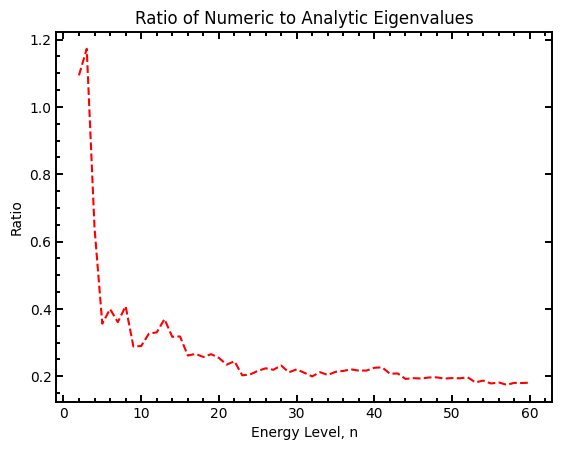

In [46]:
from matplotlib.ticker import AutoMinorLocator

har_to_j = 4.35974e-18

eigvals_si = eigvals * har_to_j # eigvals in hartree, so mult. by conversion factor to get energy in Joules

fig, ax = plt.subplots()

ax.plot(n, (eigvals_si[0:60])/sorted_ana_final[0:60], color = 'red', linestyle = '--')

ax.set_xlabel('Energy Level, n')
ax.set_ylabel('Ratio')
ax.set_title(r'Ratio of Numeric to Analytic Eigenvalues')

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax.tick_params(axis="x",direction = "in",length=5)
ax.tick_params(axis="y",direction="in",length=5)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.4)

ax.tick_params(width=1.4)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(top=True, which='minor', length=3,direction='in',width = 1.4)
ax.yaxis.set_minor_locator(AutoMinorLocator())

## Rate Constants vs. Temp

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("/Users/mohan/Desktop/Research/pib_review/data/final_comparisons.xlsx") # read in data

In [48]:
df["Gap Size"] = df["Gap Size"].astype(str) # setting type to str makes for discrete points in plot legend
df # show our data

,Temperature [K],Rate,Formalism,Gap Size
0,100,20800000,Q,2
1,200,23490000,Q,2
2,400,39990000,Q,2
3,600,64730000,Q,2
4,750,89110000,Q,2
...,...,...,...,...
155,3000,3308700000000,C,10
156,3500,3573800000000,C,10
157,4000,3820600000000,C,10
158,4500,4052400000000,C,10


In [49]:
# filtered data
df_clean = df[["Temperature [K]", "Rate", "Formalism", "Gap Size"]].dropna()
df_clean 

,Temperature [K],Rate,Formalism,Gap Size
0,100,20800000,Q,2
1,200,23490000,Q,2
2,400,39990000,Q,2
3,600,64730000,Q,2
4,750,89110000,Q,2
...,...,...,...,...
155,3000,3308700000000,C,10
156,3500,3573800000000,C,10
157,4000,3820600000000,C,10
158,4500,4052400000000,C,10


In [50]:
# take log base
df_clean['Rate [1/s]'] = np.log10(df_clean['Rate'])
df_clean

,Temperature [K],Rate,Formalism,Gap Size,Rate [1/s]
0,100,20800000,Q,2,7.318063
1,200,23490000,Q,2,7.370883
2,400,39990000,Q,2,7.601951
3,600,64730000,Q,2,7.811106
4,750,89110000,Q,2,7.949926
...,...,...,...,...,...
155,3000,3308700000000,C,10,12.519657
156,3500,3573800000000,C,10,12.553130
157,4000,3820600000000,C,10,12.582132
158,4500,4052400000000,C,10,12.607712


In [51]:
df_clean = df_clean[["Temperature [K]", "Rate [1/s]", "Formalism", "Gap Size"]].dropna()
df_clean

,Temperature [K],Rate [1/s],Formalism,Gap Size
0,100,7.318063,Q,2
1,200,7.370883,Q,2
2,400,7.601951,Q,2
3,600,7.811106,Q,2
4,750,7.949926,Q,2
...,...,...,...,...
155,3000,12.519657,C,10
156,3500,12.553130,C,10
157,4000,12.582132,C,10
158,4500,12.607712,C,10


In [52]:
import plotly.express as px
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly

fig = px.scatter(df_clean, y=r"Rate [1/s]", x="Temperature [K]", color="Gap Size", symbol="Formalism", symbol_sequence= ['diamond', 'cross'], color_discrete_sequence=px.colors.qualitative.D3)

# data set, y-values, x-values, set the parameters to distinguish between gap size and formalisnm, set symbols 

for i, trace in enumerate(fig.data):
    name = trace.name.split(',')
    trace['name'] = ''
    trace['showlegend']=False

fig.update_traces(marker=dict(size=7,line=dict(width=1, color='Black')),selector=dict(mode='markers'))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color=px.colors.qualitative.D3[0]),
                         name='2pt Gap',
                         ))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color=px.colors.qualitative.D3[1]),
                         name='4pt Gap',
                         ))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color=px.colors.qualitative.D3[2]),
                         name='6pt Gap',
                         ))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color=px.colors.qualitative.D3[3]),
                         name='8pt Gap',
                         ))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color=px.colors.qualitative.D3[4]),
                         name='10pt Gap',
                         ))

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='diamond-open', color='black'),
                         name='Quantum',
                         ))
fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='cross-open', color='black'),
                         name='Classical',
                         ))



fig.update_layout(legend=dict(title=''),
                  xaxis=dict(title=r'Temperature [K]'),
                  yaxis=dict(title=r'log(k)'))


# pio.write_image(fig, '/PATH/0pt_wall.png',scale=4, width=700, height = 500) # uncomment to save image

fig.show() # customize axis label)

## Finalized Pieces of Code 

Don't try to run `2d_slit.py` or `correlation.py` here since they won't complete any time soon.

In [ ]:
#/* --------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   2d_slit.py
#   "This file calculates eigenfunctions of particle in a box in the presence of a slit"
#-------------------------------------------------------------------------------- */
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
#-------------------------------------------------------------------------------- */
# INPUTS
me = 5.485799e-4 # Electron mass in daltons
m_au = 1.0 / me

lx = 1.0 # Angstroms
ly = 8.0 # Angstroms

a0 = 0.529177258 # Bohr radius

lx_au = lx/a0
ly_au = ly/a0 

nnx = 60 
nny = 480 

xmin = 0
xmax = lx_au

ymin = 0
ymax = ly_au

dx = (xmax-xmin)/(nnx+1)
dy = (ymax-ymin)/(nny+1)

pi = np.pi

nd = 2 # 
wall_thickness = 1
cd = np.zeros(nd) 
nn = 10000 

gap_size = 4.0
#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

def kron_sum(A1, A2):
    '''
    Assumes A1, A2 are nxn, mxm matrices where n can be equal to m
    '''
    i1 = np.identity(len(A1[0]))
    i2 = np.identity(len(A2[0]))
    return np.kron(A1,i2) + np.kron(i1, A2)


def PIB_one(points, lmax, lmin, mass, hbar=1):  
    '''
    function to return eigenvalues and eigenvectors of a Hamiltonian matrix 
    eigvals returned in array where eigvals[0] gives a float corresponding to n = 1; units of Joules since I defined my analytic formula with SI units
    eigvecs returned in array of arrays where eigvecs[:, i] (column vectors) gives an array corresponding to n = i at each point in the box defined by grid spacing dx
    '''
    dn = (lmax-lmin)/(points+1)
    dn2 = dn**2  # second derivative
    H = np.zeros((points, points)) # initialize 
    z = -pi**2/3.0  # weight for diagonal
    for i in range(points):
        for j in range(points):
            if i == j:
                H[i][j] = z # weight for diagonals of matrix
            else:
                H[i][j] = (2/(i-j)**2)*((-1)**(i-j+1))  # weights for non-diagonals
    H *= (-1/(2*mass*dn2)) # hbar = 1 hence 1/(2 * mass * dn2)
    return H
#-------------------------------------------------------------------------------- */
# CREATE MATRICES 
h1_x = PIB_one(nnx, xmax, xmin, m_au) # 1-D Hamiltonian from x points
h1_y = PIB_one(nny, ymax, ymin, m_au) # 1-D Hamiltonian from y points

H = kron_sum(h1_x, h1_y) # 2-D Hamiltonian
# STENCIL FOR FLUX ALONG DIVIDING SURFACE
for k in range(nd):
    zz = 1.0
    for j in range(nd):
        if j != k:
            zz *= ((j+1)**2) / ((j+1)**2 - (k+1)**2)
        else:
            continue
    cd[k] = zz/(2*(k+1))

print("Matrices created!")
#-------------------------------------------------------------------------------- */
# MAKE EFFUSION SLIT
i = -1

for k in range(nnx):
    for j in range(nny):
        i = i+1
        x = dx * k + xmin
        y = dy * j + ymin
        if (1.0 / a0) < y < (1.0 / a0 + wall_thickness * dy):
            if x <(0.5 * xmax - (gap_size/2.0) * dx) or x >(0.5 * xmax + (gap_size/2.0) * dx):
                H[i] = np.zeros(nnx * nny)
                H[:, i] = np.zeros(nnx * nny)
                H[i, i] = -1
print("Slit created!")
#-------------------------------------------------------------------------------- */
# CALCULATE EIGENVECTORS AND VALUES
eigvals, eigvecs = np.linalg.eigh(H) # find eigenvalues and eigenvectors
print("Eigs found!")
#-------------------------------------------------------------------------------- */
# CLEANUP OF DATA
psi = np.transpose(eigvecs) # vectors returned in column form so take transpose for easier indexing

psi = psi[np.argsort(eigvals)]
energies = eigvals[np.argsort(eigvals).real]

cut = np.where(energies > 0)
print(cut)
energies = energies[cut]
psi = psi[cut]

for i in range(len(psi)):
    normalization = np.sqrt(np.sum(psi[i]**2 * dy * dx))
    psi[i] = psi[i]/normalization

# np.savez("eigs_file", psi = psi, eigvals = eigvals)
print("Eigs saved!")
#-------------------------------------------------------------------------------- */
# FIRST DERIVATIVE OVER DIVIDING SURFACE

dpsi = np.zeros((nn, nnx))

y = (1/a0) + 1.0 * dy
i0 = int((y-ymin)/dy)

for j in range(nn):
    for i2 in range(nnx):
        ix = nny * i2 + i0
        zz = 0.0
        for k in range(nd):
            kk = k + 1
            zz += cd[k] * (psi[j][ix + kk] - psi[j][ix-kk])
        zz = zz/dy
        dpsi[j, i2] = zz

print("First derivative over dividing surface found!")
#-------------------------------------------------------------------------------- */
# CALCULATION OF FLUX SQUARED
        
fx2 = np.zeros((nn, nn))

for j1 in range(nn):
    for j2 in range(nn):
        zz = 0.0
        for i2 in range(nnx):
            ix = nny * i2 + i0
            zz0 = dpsi[j1, i2] * psi[j2, ix] - psi[j1, ix] * dpsi[j2, i2]
            zz0 = zz0 * dy / (2.0 * m_au)
            zz += zz0
        zz = zz**2
        fx2[j1, j2] = zz

with open("Energy.npz", "wb") as f:
    np.savez(f, energies = energies, fx2 = fx2, )

print("Job was successfully completed!")
#-------------------------------------------------------------------------------- */

In [ ]:
#/* --------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   correlation.py
#   "This code calculates correlation functions for a given system in parallel"
#-------------------------------------------------------------------------------- */
# DEPENDENCIES
import numpy as np
from multiprocessing import Pool # relevant package for parallel processing temperatures
from datetime import datetime
#-------------------------------------------------------------------------------- */
# INPUTS & LOAD IN DATA (PART 1)

start_time = datetime.now()
print("Starting!", start_time)
kb = 3.166830e-6 # Boltzmann constant in hartree
har = 2.194746e5 # hartree in cm^{-1}

Trange = np.array([100, 200, 400, 600, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

tmin = 0
tmax = 10000
nt = 1000
dt = (tmax - tmin)/nt

hbar = 1.0

with np.load('Energy.npz') as data:
    E = np.array([data['energies']])
    fx2 = data['fx2']

nn = np.shape(fx2)[0]
# print("Energies", E)
epsilon= np.log(1e-16)
zero = E[0]
dE = E - E.transpose()
sE = E + E.transpose()

dEm = dE.copy()

np.fill_diagonal(dEm, 1)

ttot = np.arange(tmin, tmax+1, dt)
CF = np.zeros((2, nt+1))
CS = np.zeros((2, nt+1))
CF[0] = ttot
CS[0] = ttot

end_time =  datetime.now()
print('Duration of Part One: {}'.format(end_time - start_time))
#-------------------------------------------------------------------------------- */
# Correlation Functions (PART 2)

start_time = datetime.now()

def f(T):
    beta = 1/(kb*T)
    cut = 2 * epsilon/beta 
    over = np.where(E > zero - cut)
    if np.shape(over) == 0:
        print(f'Not converged at {T}')
        Q = nn
    else:
        print(f'At {T}K, {over[0]} functions are significant')
        if over[0] <= nn:
            Q = over[0]
        else:
            Q = nn

    for time in range(nt + 1):
        t = tmin + time * dt
        zz = np.exp(-beta * 0.5 * sE[0:Q, 0:Q]) * fx2[0:Q, 0:Q]
        CF1 = zz * np.cos(dE[0:Q, 0:Q] * t)
        zzd = np.diagonal(zz)
        CS1 = zz * np.sin(dE[0:Q, 0:Q] * t) / dEm[0:Q, 0:Q]
        CSd = zzd * t
        np.fill_diagonal(CS1, CSd)

        CF[1, time] = np.sum(CF1)
        CS[1, time] = np.sum(CS1)
        
    return CS, CF

if __name__ == '__main__':
    #num_cores=os.getenv('SLURM_CPUS_PER_TASK') # get number of cores based on slurm script
    pool = Pool(processes=10) # use as many cores as allocated by slurm script
    fargs=zip(Trange)

    result = pool.starmap(f, fargs) # result is a list of all returned values for CS, CF at a given T in order (i.e. at Trange[i]: CS = results[i][0], CF = results[i][1])

    # result is a 4-D object; result[a][b][c][d] --> a denotes which temp;
    # b = 0 --> CS; b = 1 --> CF
    # [c][d] are then indices for a 2D matrix where the first column
    # corresponds to time and the second the relevant correlation function

    for i, val in enumerate(Trange):
        np.savetxt('side-flux'+str(val)+'K.txt', np.transpose((result[i][0][0], result[i][0][1])), delimiter = ',', header="Time , Side-Flux", fmt='%1.4e') 

    # result[i][a][b] means Trange[i]; [a] = 0 means Flux-Side (CS);
    # [b] = 0 means time column; b = 1 means correlation function;
    # free index [d] corresponds to a particular element in column so it's unused

    for i, val in enumerate(Trange):
        np.savetxt('flux-flux'+str(val)+'K.txt', np.transpose((result[i][1][0], result[i][1][1])), delimiter = ',', header="Time , Flux-Flux", fmt='%1.4e') 
    
    # result[i][a][b] means Trange[i]; [a] = 1 means Flux-Flux (CF) [b] = 0 means
    # time column while b = 1 means correlation function;
    # [c][d] are then indices for a 2D matrix where the first column
    # corresponds to time and the second the relevant correlation function

    pool.close()
    pool.join()


end_time =  datetime.now()
print('Duration of Part Two: {}'.format(end_time - start_time))
#-------------------------------------------------------------------------------- */

## Rate Constant Finder:

Formally, we would have to find the limit as t $\to \infty$ for the flux-side correlation function to ascertain the rate constants, but that not possible since due to the oscillatory nature of the sinusoidal function. Instead what we can do is find the limit at an intermediate time, treating that as the long-time limit. It's more an art than a science, but the following code makes it a bit more quantitative. 

For the code below, it's important to note the structure of my directories, but first:

Let G = {2, 4, 6, 8, 10} be the set of gap sizes used 
Let W = {1, 2, 3, 4, 5} be the set of wall thicknesses used

g $\in$ G and w $\in$ W are elements of G and W respectively. I will use them to denote an arbitrary gap size of wall thickness in the directory below.

```
project
│   README.md
│   file001.txt    
│
└───wpt_wall
│   │
│   └───gpt_gap
│   |   │   side-fluxtK.txt
│   |   │   side-fluxtK.txt.txt
│   |   │   ...
│   └───gpt_gap
│       │   side-fluxtK.txt
│       │   side-fluxtK.txt
│       │   ...
│   
└───wpt_wall
│   │
│   └───gpt_gap
│   |    │   side-fluxtK.txt
│   |    │   side-fluxtK.txt
│   |    │   ...
│   └────gpt_gap
│        │   side-fluxtK.txt
│        │   side-fluxtK.txt
│        │   ...
|
└─── ...
```

What this shows is that the different wall thicknesses are all contained in the same parent directory, and the different gap sizes are sub-directories within the wall thickness folders.

Partition Functions: 
 [8.63930324e-03 9.82193204e-02 4.22178739e-01 8.24743160e-01
 1.15425738e+00 1.73690949e+00 2.34854034e+00 2.98075566e+00
 3.62856891e+00 4.28873106e+00 5.63768857e+00 7.01575693e+00
 8.41588408e+00 9.83347522e+00 1.12653388e+01 1.27091510e+01]
Tuples (40, 482)
Tuples (489, 526)
Tuples (543, 576)
Tuples (624, 646)
Tuples (662, 694)
Tuples (749, 975)
Number of index used 261.0
Value of csf 1.3313e-06
Time 2610.0
Rate [Hz] [2.9386848e+09]
Truncated Rate [Hz] [2.939e+09]


/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_4390/137975361.py:87: RuntimeWarning:

invalid value encountered in divide



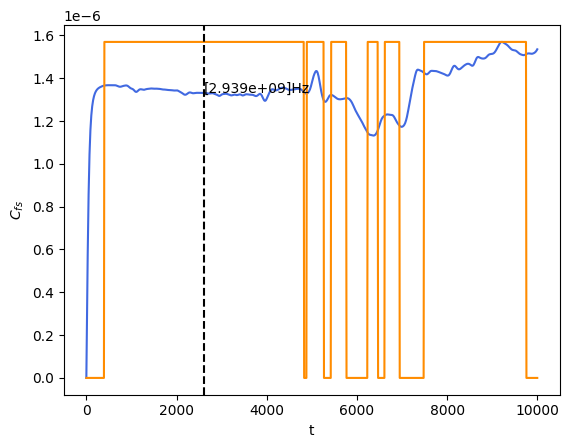

In [25]:
#/* -------------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   rate_calculator.py
# "This code finds plateaus for f-s correlation fncs in order to calculate rate constants"
#---------------------------------------------------------------------------------------- */

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Trange = np.array([100, 200, 400, 600, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

hbar = 1.054571817e-34 # hbar in SI Units [J*s]

m = 1.67262192e-27 # mass of proton in kg

L = 1e-10 

kb = 1.380649e-23

#-------------------------------------------------------------------------------- */
# Calculate Partition Functions
n = np.arange(1, 21, 1)
Q = np.empty(shape = len(Trange)) # initialize empty array of dimensions equal to Trange
E = (np.pi ** 2 * hbar ** 2) / (2 * m * L ** 2)

for i, temp in enumerate(Trange):
    T = temp
    beta = 1 / (kb * T)
    zz = np.exp(-beta * E * n** 2)
    final = np.sum(zz)
    Q[i] = final**2

print("Partition Functions: \n", Q)

#-------------------------------------------------------------------------------- */
# FUNCTION DEFINITIONS

T = 1500 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE TEMPERATURE

chunk_size = 50 # NUMBER OF POINTS FORWARD AND BACK TO CONSIDER IN DERIV.

wall_size = 3 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE WALL SIZE

gap_size = 6 # CHANGE THIS TO GRAB A DIFFERENT FLUX-SIDE GAP SIZE


temp_index = np.where(Trange == T) # get index of Trange array where the temperature match 
#-------------------------------------------------------------------------------- */
# READ IN DATA

df = pd.read_csv("/Users/mohan/Desktop/Research/pib_review/data/"+str(wall_size)+"pt_wall/"+str(gap_size)+"pt_gap/side-flux"+str(Trange[temp_index][0])+"K.txt") # read in data

# df = pd.read_csv("/Users/mohan/Desktop/Refile/2pt_wall/6pt_gap/side-flux"+str(Trange[temp_index][0])+".txt", sep = ' ', header = None).T # if Alec style; my 2 pt wall, 6pt gap are Alec style

t = df.iloc[:, 0].to_numpy() # first column is time array
c = df.iloc[:, 1].to_numpy() # second column is correlation function array

#-------------------------------------------------------------------------------- */
# DEFINE FUNCTIONS
def zero_slope(data, chunksize = chunk_size, max_slope = .04): # function to find where the numerical derivative is ~ 0 based on chunk size 
    # (looking at points forwards and backwards) and max_slope
    midindex = chunksize / 2
    is_plateau = np.zeros((data.shape[0]))
    for index in range(int(midindex), len(data) - int(midindex)):
        front = index - midindex
        back = index + midindex
        chunk = data[int(front) : int(back)]
        dy_dx = abs(chunk[0] - chunk[-1])/chunksize
        if (0 <= dy_dx < max_slope):
            is_plateau[index] = 1.0
    return is_plateau

def ranges(nums): # return tuples of consecutive integers (i.e. find "widths" of plateaus in step function)
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
#-------------------------------------------------------------------------------- */
# ANNOYING STUFF
small = np.nanmin(c/t) # find min of c/t wile dropping NaN values

step_function = zero_slope(data = c, chunksize = chunk_size, max_slope = small*10) # array of all 0's and 1's based on where the plateaus are

indices = [idx for idx,val in enumerate(step_function) if val == 1] # grab indices where value is 1

new = ranges(indices) # create tuples of consecutive numbers (i.e. find indices for each plateau)

lengths = np.zeros(len(new)) # make empty array with same dimensions as "new" array 

for i, val in enumerate(new): # print out tuples
    print("Tuples", val)
    lengths[i] = val[1] - val[0] 

#-------------------------------------------------------------------------------- */
# NUMERICALLY FIND LARGEST PLATEAU AND SET INDEX (`use_this`) TO THE MIDDLE INDEX OF LONGEST PLATEAU

max_value = max(lengths)
max_index = list(lengths).index(max_value)

largest_tuple = new[max_index]

# automatically find widest plateau numerically
# index for y value of csf we want to use for calculating the rate 

use_this = (largest_tuple[0] + (largest_tuple[1] - largest_tuple[0])/2)

# use_this = (40 + (59 - 40)/2) # manually set index for widest plateau; index for y value of csf we want to use for calculating the rate 

print("Number of index used", use_this)

csf = c[int(use_this)]

print("Value of csf", csf)

print("Time", t[int(use_this)])

rate = (csf/Q[temp_index]) * 6.57966e15 # rate; multiply hartree value by conversion factor to get Hz
print("Rate [Hz]", rate)
short_rate = np.around(rate, decimals = -6)
print("Truncated Rate [Hz]", short_rate)
#-------------------------------------------------------------------------------- */
# PLOT
plt.plot(t, c, color = 'RoyalBlue')
plt.plot(t, step_function*np.nanmax(c), color = 'darkorange') # scale the step function by the maximum of the correlation function so that plotting makes sense
plt.axvline(x = t[int(use_this)], color = 'k', linestyle = '--', label = 'plateau value')
plt.text(t[int(use_this)], c[int(use_this)] + np.nanmin(c), str(short_rate)+"Hz")
plt.xlabel("t")
plt.ylabel(r"$C_{fs}$")
# plt.savefig("/Users/mohan/Desktop/well-behaved_ff_1000k_2wall_6gap.png", dpi = 500)
plt.show()

In [35]:
#/* -------------------------------------------------------------------------------------
#   Egorov Group
#   University of Virginia
#   Mohan Shankar
#
#   rate_extrapolator.py
# "This code extrapolates rate constants as wall thickness tends to zero"
#---------------------------------------------------------------------------------------- */

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Trange = np.array([100, 200, 400, 600, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

gaps = np.array([2, 4, 6, 8, 10])

df = pd.read_excel("/Users/mohan/Desktop/Research/pib_review/data/extrap_rate_plot.xlsx").dropna() # read in data 

extrap_rates = np.zeros((len(Trange), len(gaps))) # matrix where constant T across row, constant gap size down a column
extrap_errors = np.zeros((len(Trange), len(gaps))) # matrix where constant T across row, constant gap size down a column
ratio_rates_error = np.zeros((len(Trange), len(gaps))) # matrix where constant T across row, constant gap size down a column

for i, T in enumerate(Trange):
    for j, gap_size in enumerate(gaps):
        filtered_df = df[(df['Temperature [K]'] == T) & (df['Gap Size'] == gap_size)]
        result = filtered_df.head(5) # Take the first five rows that meet the criteria
        
        wall_thickness = result.iloc[:, 1]
        rates = result.iloc[:, -1]
        
        order = 2

        fit, cov_matrix = np.polyfit(wall_thickness, rates, order, cov = True) # fit 2nd order polynomial to data and return covariance matrix

        errors = np.sqrt(np.diag(cov_matrix))

        extrap_rates[i][j] = fit[-1] # assign i, j element the y-int which corresponds to wall thickness = 0

        extrap_errors[i][j] = errors[-1] # assign i, j element the y-int error 

        ratio_rates_error[i][j] = np.abs( fit[-1] / errors[-1] )


gaps = np.array([0, 2, 4, 6, 8, 10])

final_extrap_rates = np.row_stack((gaps, np.column_stack((Trange, extrap_rates)))) # add leftmost column vector denoting temp and topmost row vector denoting gap size

final_extrap_errors = np.row_stack((gaps, np.column_stack((Trange, extrap_errors)))) # add leftmost column vector denoting temp and topmost row vector denoting gap size

final_ratio_errors = np.row_stack((gaps, np.column_stack((Trange, ratio_rates_error)))) # add leftmost column vector denoting temp and topmost row vector denoting gap size


# SAVE RESULTS AS CSV

# np.savetxt('/Users/mohan/Desktop/extrap_rates.csv', final_extrap_rates, delimiter=',') # CHANGE PATH
# np.savetxt('/Users/mohan/Desktop/extrap_error.csv', final_extrap_errors, delimiter=',') # CHANGE PATH
# np.savetxt('/Users/mohan/Desktop/extrap_ratio.csv', final_ratio_errors, delimiter=',') # CHANGE PATH

